# Mushroom Image Classifier - Iterative Development

## Overview

This Iterative Development document consists of three main changes upon the baseline, with parameter justification throughout to help explain reasoning for changes made.

#### Section 1- Expanded Dataset

Section 1 showcases the first change, the addition of new raw training data.
Web scrapers (available in the repository) where used in the creation of a new dataset folder "shroomEPImagesAdditional", this folder contains the original mushroom.world dataset images compiled with the folders created by the wikipedia and foraging guide web scrapers.

We have also implemented techniques to increase the speed of training in this section.

#### Section 2 - Data Augmentation and Configuation of the Model

Section 2 builds upon Section 1, however other iterative development techniques have been implemented, such as data augmentation and changes to the model.

#### Section 3 - Evaluation Documents

Links to external pipeline and model evaluation documents can be found in relevant places throughout the document for added readability, however the links have been colated at the bottom of the document for convenience.

#### Section 4 - Results
A brief comparison of results between the baseline implementation and the final model accuracy.

## Section 1 - Expanded Dataset

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import cv2
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


/Users/admin/Dropbox/Second Year/Software Engineering/Assessment/shrooming/shroomEPImagesAdditional


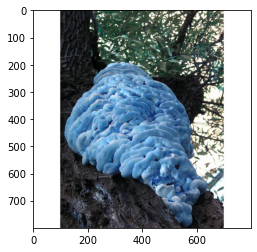

In [2]:
import pathlib
#dataset updated from "shroomEPImages" to "shroomEPImagesAdditional"
myFile = 'shroomEPImagesAdditional'
data_dir = os.path.abspath("./" + myFile) 
print(data_dir)


categories = ['edible', 'poisonous']
#loop through category names
for category in categories:
    #append category name from array into the full path
    path = os.path.join(data_dir, category)
    #loop through each image within the full path
    for img in os.listdir(path):
        #add images to array
        img_array = cv2.imread(os.path.join(path,img))
        #display data as an image
        plt.imshow(img_array)
        plt.show
        break
    break
    #display image
    print(img_array)

### Parameter Justification:

#### Batch Size:
A batch size of 32 provided optimal training accuracy for our model. Although larger batch sizes allow computational speedups from the parallelism of GPUs, too large of a batch size can lead to poor generalization, as the model will train on more noise from samples and therfore increase overfitting.

#### Image height, Image width:
These two parameters are used to re-size images and define image dimensions later on in the creation of augmented data to artificially increase dataset size.
180x180 provided the optimal accuracy for our model whilst keeping the training time to a managable level.
One test run resizing images to 512x512 pixels did observe a negligable accuracy increase, although the training time was increased by 1500%, so the image height and width parameters where reverted back to the original dimensions used in the baseline implementation.

In [3]:
batch_size = 32
img_height = 180
img_width = 180

import pathlib
myFile = 'shroomEPImagesAdditional'
data_dir = os.path.abspath("./" + myFile) # or similar, depending on your scenario


### Parameter Justification:

#### Validation Split:
We have used the Pareto principle to agree an 80/20 training validation split for our dataset, as this is widely agreed to be an optimal ratio.

In [4]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1184 files belonging to 2 classes.
Using 948 files for training.


In [5]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1184 files belonging to 2 classes.
Using 236 files for validation.


In [6]:
#verify class names are correct
class_names = train_ds.class_names
print(class_names)

['edible', 'poisonous']


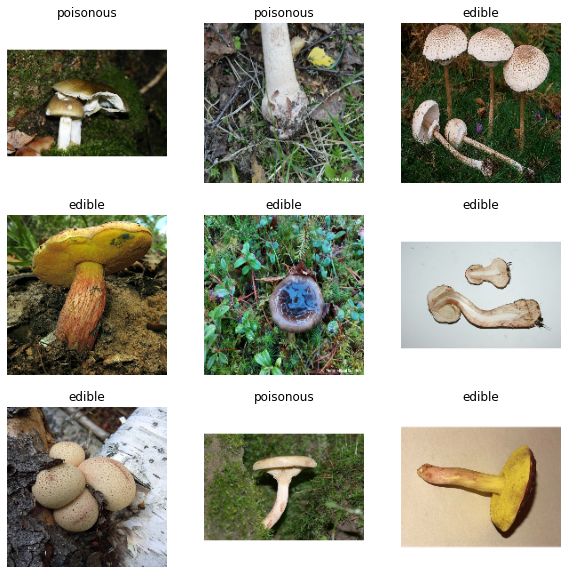

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [8]:
#check shape of batch 
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


# Configuring the dataset for performance:

Using Dataset.cache() we can keep images in memory after they have been loaded during the first epoch.
Keeping the images in memory ensures there is no bottleneck when training the model.

Using Dataset.prefetch() overlaps data preprocessing and model execution while training

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Creating the model:

### Parameter Justification:

#### CNN model:
CNN model is left the same as baseline implementation in section 1, so we can compare the results of having additional data with the results of the baseline implementation.

#### Optimizer:
Optimizer is left the same as baseline implementation in section 1, so we can compare the results of having additional data with the results of the baseline implementation.



In [10]:
num_classes = 2

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

Compile the model:

Currently using adam optimiser

In [11]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

In [13]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
30/30 [==============================] - 28s 751ms/step - loss: 0.8312 - accuracy: 0.6435 - val_loss: 0.4760 - val_accuracy: 0.7839
Epoch 2/10
30/30 [==============================] - 21s 690ms/step - loss: 0.5171 - accuracy: 0.7450 - val_loss: 0.4803 - val_accuracy: 0.7924
Epoch 3/10
30/30 [==============================] - 20s 674ms/step - loss: 0.4836 - accuracy: 0.7568 - val_loss: 0.4766 - val_accuracy: 0.7966
Epoch 4/10
30/30 [==============================] - 20s 654ms/step - loss: 0.4407 - accuracy: 0.7657 - val_loss: 0.5001 - val_accuracy: 0.7797
Epoch 5/10
30/30 [==============================] - 20s 650ms/step - loss: 0.3981 - accuracy: 0.8149 - val_loss: 0.5552 - val_accuracy: 0.7881
Epoch 6/10
30/30 [==============================] - 20s 679ms/step - loss: 0.3245 - accuracy: 0.8579 - val_loss: 0.6172 - val_accuracy: 0.7585
Epoch 7/10
30/30 [==============================] - 21s 684ms/step - loss: 0.3200 - accuracy: 0.8637 - val_loss: 0.6671 - val_accuracy: 0.7415

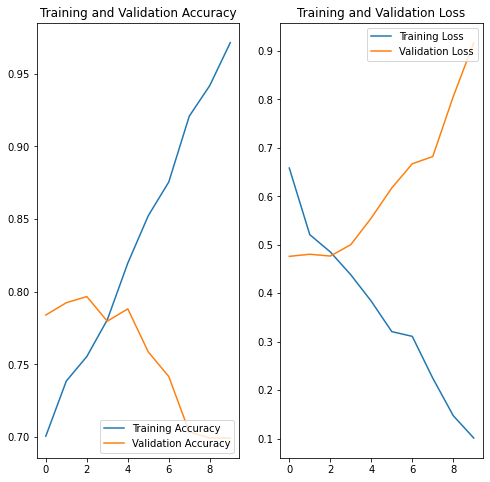

Mean Validation Accuracy:0.7542372822761536
Mean Validation Loss:0.6177209854125977
Mean Training Accuracy:0.8356540083885193
Mean Training Loss:0.3589988648891449


In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#additional code to show mean training and validation accuracy and loss  
print("Mean Validation Accuracy:" + str(np.mean(val_acc)))
print("Mean Validation Loss:" + str(np.mean(val_loss)))

print("Mean Training Accuracy:" + str(np.mean(acc)))
print("Mean Training Loss:" + str(np.mean(loss)))

predict on new data:

In [15]:
mushroom_url = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRCNEyMK_tgLK3bF-zKcHG5loKontPWeNhLcA&usqp=CAU"
mushroom_path = tf.keras.utils.get_file('test_shroom', origin =mushroom_url)

img = keras.preprocessing.image.load_img(
    mushroom_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to poisonous with a 98.17 percent confidence.


## Section 2 - Data Augmentation and configuation of the model

## Data Augmentation

Validation stalls at around 79% accuracy and then drops off, which is a sign of overfitting, this is likely due to the small number of training samples.

One way to artificially increase the number of training samples is to generate more augmented versions of the existing mushroom photos.

### Parameter Justification:

Pipeline Evaluation document collated by Eve O'Brien goes into further detail as to changes made to the entire pipeline:

https://github.com/SteviePreston/KF5002-Mushroom/blob/main/IterativeDevelopmentFiles/Pipeline%20Evaluations.docx

#### Random Flip:
A horizontal flip is appropriate for augmented data, as realistically most images of mushrooms are going to be taken the correct orientation, the only variation being which way (left or right) the mushrooms are pointing.

#### Random Rotation and Zoom:
A rotation of and zoom range of no more than .1 (10%), will be sufficient for this application, on the assumption that most images of mushrooms taken for identification purposes are going to be relatively straight and will contain the same average amount of background noise as the images used in training.



In [16]:
data_augmentation = keras.Sequential(
[
 layers.experimental.preprocessing.RandomFlip("horizontal",
                                             input_shape=(img_height,
                                                         img_width,
                                                         3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
]
)

Visualise the augmented examples:

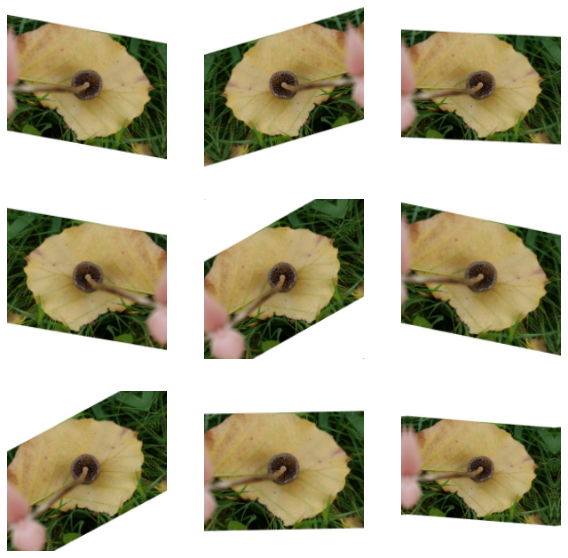

In [17]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

## Optimising the CNN Model

### Parameter Justification:

Model Evaluation document collated by Steven Preston goes into further detail as to changes made to the model:

https://github.com/SteviePreston/KF5002-Mushroom/blob/main/IterativeDevelopmentFiles/Model_Evaluations.docx

#### Dropout Layer:
One technique to reduce overfitting is by using a form of regularisation known as Dropout.
Dropout randomly sets the activation number of output units from the layer to 0 during the training process.

#### Softmax activation in dense layer:
Model evaluation involved testing different combinations of activation functions on the convolutional layers. The highest mean validation accuracy was achieved by keeping the first 3 layers using a "ReLU" activation function, but using a SoftMax function for the 4th, Fully connected layer. We found this change increased mean validation accuracy from 72.2% to 78.39% in testing.
We also added some code after training to get an accurate reading of mean validation accuracy and loss.

#### Optimizer
Model evalutation revealed a constant mean validation accuracy across all trialed optimizers, however Adagrad achieved the lowest mean validation loss of 50.71%, compared to the original validation loss of 54.84% achieved by the adam optimizer used in the baseline implementation.

In [18]:
model = Sequential([
    data_augmentation,
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='softmax'),
    layers.Dense(num_classes)
])
  

Compiling the altered model:

In [19]:
model.compile(optimizer='adagrad',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)       

In [21]:
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
30/30 [==============================] - 26s 835ms/step - loss: 0.6902 - accuracy: 0.7276 - val_loss: 0.6862 - val_accuracy: 0.7839
Epoch 2/10
30/30 [==============================] - 27s 897ms/step - loss: 0.6872 - accuracy: 0.7260 - val_loss: 0.6836 - val_accuracy: 0.7839
Epoch 3/10
30/30 [==============================] - 25s 835ms/step - loss: 0.6856 - accuracy: 0.7150 - val_loss: 0.6814 - val_accuracy: 0.7839
Epoch 4/10
30/30 [==============================] - 23s 753ms/step - loss: 0.6839 - accuracy: 0.7179 - val_loss: 0.6796 - val_accuracy: 0.7839
Epoch 5/10
30/30 [==============================] - 23s 758ms/step - loss: 0.6830 - accuracy: 0.7092 - val_loss: 0.6780 - val_accuracy: 0.7839
Epoch 6/10
30/30 [==============================] - 25s 824ms/step - loss: 0.6801 - accuracy: 0.7402 - val_loss: 0.6764 - val_accuracy: 0.7839
Epoch 7/10
30/30 [==============================] - 27s 901ms/step - loss: 0.6796 - accuracy: 0.7291 - val_loss: 0.6750 - val_accuracy: 0.7839

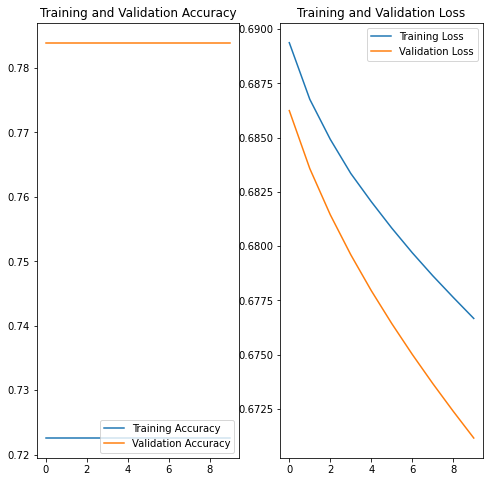

Mean Validation Accuracy:0.7838982939720154
Mean Validation Loss:0.6777524471282959
Mean Training Accuracy:0.7225738167762756
Mean Training Loss:0.6819957911968231


In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#additional code to show mean training and validation accuracy and loss 
print("Mean Validation Accuracy:" + str(np.mean(val_acc)))
print("Mean Validation Loss:" + str(np.mean(val_loss)))
print("Mean Training Accuracy:" + str(np.mean(acc)))
print("Mean Training Loss:" + str(np.mean(loss)))

In [24]:
#mushroom url variable to paste in images of mushroom to be classified
mushroom_url = "https://www.lovethegarden.com/sites/default/files/content/articles/UK_oyster-mushrooms-growing.jpg"
#get everything after the last ' / ' in the url to be used as filename
file_name = mushroom_url.rsplit('/',1)[-1]
mushroom_path = tf.keras.utils.get_file(file_name, origin =mushroom_url)

img = keras.preprocessing.image.load_img(
    mushroom_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to edible with a 51.98 percent confidence.


## Section 3 - Evaluation Documents

#### Pipeline Evaluations- Produced by Eve O'Brien:

https://github.com/SteviePreston/KF5002-Mushroom/blob/main/IterativeDevelopmentFiles/Pipeline%20Evaluations.docx

#### Model Evaluations- Produced by Steven Preston:

https://github.com/SteviePreston/KF5002-Mushroom/blob/main/IterativeDevelopmentFiles/Model_Evaluations.docx


## Section 4 - Results

Using the forementioned iterative development techniques we have achieved an increase in mean validation accuracy of 12%, from 66% achieved in the baseline implementation to %78 achieved here in the iterative development document.
